# Trigram using Neural Network

In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

## Data Prep

In [2]:
words = open("./names.txt", 'r').read().splitlines()

In [3]:
train_words, temp_words = train_test_split(words, train_size=0.8, random_state=42)
dev_words, test_words = train_test_split(temp_words, test_size=0.5, random_state=42)

In [4]:
len(train_words), len(dev_words), len(test_words)

(25626, 3203, 3204)

In [5]:
chars = sorted(list(set(''.join(train_words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

two_chars = set()
for c1 in chars+["."]:
    for c2 in chars+["."]:
        two_chars.add(c1+c2)

two_chars = sorted(list(two_chars))

stoi2 = {s:i for i,s in enumerate(two_chars)}
itos2 = {i:s for i,s in enumerate(two_chars)}

N = torch.zeros((729, 27), dtype=torch.int32)

## Trigram NN

In [6]:
xs, ys = [], []
for w in train_words:
    chs = ["."] + list(w) + ["."]
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi2[ch1+ch2]
        ix2 = stoi[ch3]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

W = torch.empty(0)

In [7]:
dev_xs, dev_ys = [], []
for w in dev_words:
    chs = ["."] + list(w) + ["."]
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi2[ch1+ch2]
        ix2 = stoi[ch3]
        dev_xs.append(ix1)
        dev_ys.append(ix2)

dev_xs = torch.tensor(dev_xs)
dev_ys = torch.tensor(dev_ys)

In [8]:
test_xs, test_ys = [], []
for w in test_words:
    chs = ["."] + list(w) + ["."]
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi2[ch1+ch2]
        ix2 = stoi[ch3]
        test_xs.append(ix1)
        test_ys.append(ix2)

test_xs = torch.tensor(test_xs)
test_ys = torch.tensor(test_ys)

### Training

In comparison to the statistical model, the neural network weights are essentially trained to represent the dataset's probability distribution.

In [9]:
def get_epoch_loss(weights, word_set):
    if (word_set == "dev_words"):
        xs = torch.tensor(dev_xs)
        ys = torch.tensor(dev_ys)
    else:
        xs = torch.tensor(test_xs)
        ys = torch.tensor(test_ys)

    with torch.no_grad():
        logits = weights[xs]
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
    
        nll = -probs[torch.arange(xs.nelement()), ys].log().mean()

    return nll.item()

In [10]:
def train(reg_factor=0.0550, epochs=150):
    global W
    g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((729, 27), generator=g, requires_grad=True)

    train_losses = {}
    dev_losses = {}
    test_losses = {}

    for i in range(epochs):
        # forward pass
        logits = W[xs]
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        loss = -probs[torch.arange(xs.nelement()), ys].log().mean() + reg_factor*(W**2).mean()
    
        train_losses[i] = loss.item()
        dev_losses[i] = get_epoch_loss(W, "dev_words")
        test_losses[i] = get_epoch_loss(W, "test_words")
    
      # backward pass
        W.grad = None
        loss.backward()
        with torch.no_grad():
            W.data += -75 * W.grad

    return (train_losses, dev_losses, test_losses)

In [ ]:
train_losses, dev_losses, test_losses = train();

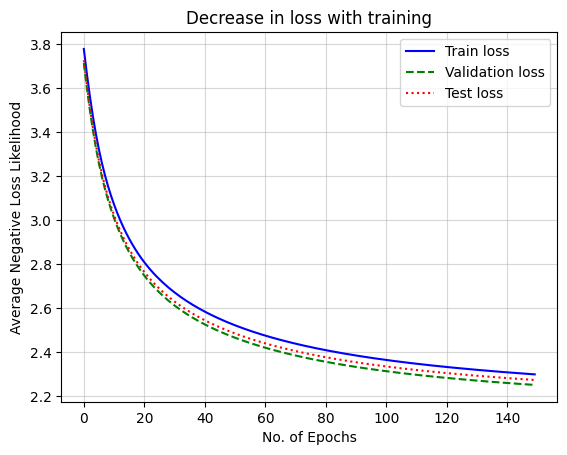

In [12]:
plt.plot(train_losses.keys(), train_losses.values(), 'b-', label="Train loss")
plt.plot(dev_losses.keys(), dev_losses.values(), 'g--', label="Validation loss")
plt.plot(test_losses.keys(), test_losses.values(), 'r:', label="Test loss")
plt.xlabel("No. of Epochs")
plt.ylabel("Average Negative Loss Likelihood")
plt.legend()
plt.title("Decrease in loss with training")
plt.grid(alpha=0.5)
plt.show()

### Sampling from the Neural Network Model

In our tests, using the same seed (from the same library) for sampling in the statistical model and the neural network model gave nearly the same outputs. We do not show that here because we have used NumPy in the earlier notebook in view of demonstrating usage of multiple libraries.

In [13]:
g = torch.Generator().manual_seed(2147483647)
for _ in range(10):
  ix = 1
  out = ["."]
  while True:
    if ix != 1:
      ix = stoi2[''.join(out[-2:])]
    with torch.no_grad():
        logits = W[ix]
        counts = logits.exp()
        probs = counts / counts.sum() 
      
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    out.append(itos[ix])
        
    if out[-1][-1] == ".":
      break
  
  print(''.join(out))

.luwjde.
.ilyasiz.
.ufofyywocnzq.
.di.
.ritoniabraree.
.viameiauriniadvhassdbyainrwibwlassiyanaylartleigvmumtrifoetumj.
.nonn.
.lenariani.
.rose.
.yae.


### Evaluation

In [14]:
def get_loss(word_set):
    xs_t, ys_t = [], []
    for w in word_set:
        chs = ["."] + list(w) + ["."]
        for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi2[ch1+ch2]
            ix2 = stoi[ch3]
            xs_t.append(ix1)
            ys_t.append(ix2)
    
    xs_t = torch.tensor(xs_t)
    ys_t = torch.tensor(ys_t)

    with torch.no_grad():
        logits = W[xs_t]
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
    
        nll = -probs[torch.arange(xs_t.nelement()), ys_t].log().mean()

    return nll.item()

In [15]:
train_nll = get_loss(train_words)
print("--- Train split loss ---")
print(f"Avg NLL: {train_nll:.4f}")

--- Train split loss ---
Avg NLL: 2.2437


In [16]:
dev_nll = get_loss(dev_words)
print("--- Dev split loss ---")
print(f"Avg NLL: {dev_nll:.4f}")

--- Dev split loss ---
Avg NLL: 2.2488


In [17]:
test_nll = get_loss(test_words)
print("--- Test split loss ---")
print(f"Avg NLL: {test_nll:.4f}")

--- Test split loss ---
Avg NLL: 2.2713


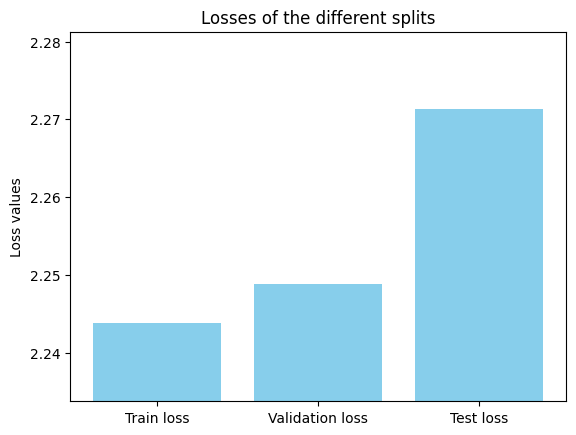

In [18]:
split_losses = [train_nll, dev_nll, test_nll]
loss_names = ["Train loss", "Validation loss", "Test loss"]

plt.bar(loss_names, split_losses, color="skyblue")
plt.ylim(min(split_losses) - 0.01, max(split_losses)+0.01)

plt.ylabel("Loss values")
plt.title("Losses of the different splits")
plt.show()

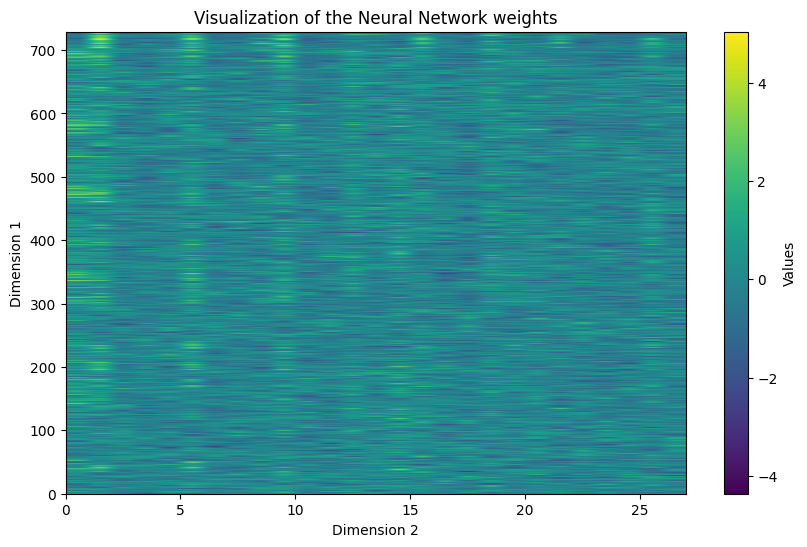

In [19]:
plt.figure(figsize=(10, 6))
plt.imshow(W.detach(), cmap='viridis', aspect='auto', extent=[0, 27, 0, 729])
plt.colorbar(label='Values')

plt.xlabel('Dimension 2')
plt.ylabel('Dimension 1')
plt.title('Visualization of the Neural Network weights')

plt.show()

# References

Karpathy, A., [Andrej Karpathy]. (2022, September 8). <i>The spelled-out intro to language modeling: building makemore</i> [Video]. YouTube. https://www.youtube.com/watch?v=PaCmpygFfXo

Jurafsky, Daniel and James H. Martin. <i>N-Gram Language Models</i>. 3 Feb. 2023, https://web.stanford.edu/~jurafsky/slp3/3.pdf.

# Appendix

To further demonstrate the empirical equivalence of the statistical and the neural network model, we refer you to the video provided in the first reference source.